# Task 2: 量子模拟器实现

In [1]:
# 实现的两个包
from circuit import Circuit, CNOT, U3  #

import time
from numpy import pi
import numpy as np

## 初始化电路

In [2]:
qubit_numer = 2
qc = Circuit(qubit_numer) # 有两个比特[0,1]

### 电路提供了两种门 CNOT门 和 U3 门。

1. U3 是一个单比特门, 除了连接的比特，有三个参数 theta、lambda、phi。
2. CNOT 是一个两比特门， 除了连接的两个比特，没有参数

In [3]:
u3 = U3(0, pi/2, pi/3, pi/4)  # 参数：作用的比特位置，theta、lambda、phi
qc.addGate(u3)  # 将其加入电路中
u3.matrix()  # 一个u3门对应一个2X2的矩阵

array([[ 0.70710678+0.j        , -0.35355339-0.61237244j],
       [ 0.5       +0.5j       , -0.1830127 +0.6830127j ]])

In [6]:
cnot = CNOT(0,1) # 参数：作用的比特位置
qc.addGate(cnot) 
cnot.matrix()  # 一个cnot门对应一个4X4的矩阵

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [7]:
qiskit_qc = qc.toQiskit()
print(qiskit_qc)  # qiskit上是反着的

     ┌─────────────────┐          
q_0: ┤ U3(π/2,π/4,π/3) ├──■────■──
     └─────────────────┘┌─┴─┐┌─┴─┐
q_1: ───────────────────┤ X ├┤ X ├
                        └───┘└───┘


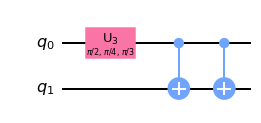

In [8]:
# 也可以画的更好看些
qiskit_qc.draw('mpl')

Circuit.random(gate_number) 用于生成一个随机的电路

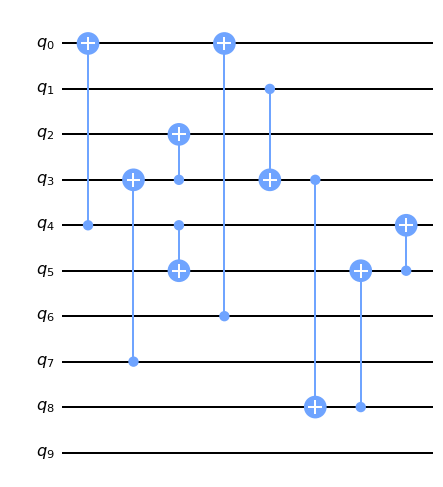

In [9]:
random_qubit_number = 10
random_qc = Circuit(random_qubit_number)
random_qc.random(20)
random_qc.toQiskit().draw('mpl')

## 模拟

In [8]:
from simulator import simulate

In [15]:
start_time = time.time()
init_state = np.zeros(2**random_qubit_number)  
init_state[0] = 1  # 定义初始态, 一个 (1, )
final_state = simulate(random_qc, init_state)
print('cost:', time.time() - start_time, 's')

cost: 3.847222089767456 s


In [16]:
final_state  #结束态

array([-0.01990314+0.13622117j,  0.        +0.j        ,
        0.        +0.j        , ...,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [17]:
print(init_state.shape, final_state.shape)  # 初始态和结束态都是一个(2**qubit_number)的数组

(1024,) (1024,)


和开源库对比验证下

In [18]:
from qiskit.quantum_info import Operator
verified_qc = random_qc.toQiskit().reverse_bits() # qiskt是小端, 我们这里是大端
mat = Operator(verified_qc).data
verified_state = mat @ init_state
print(np.allclose(final_state, verified_state))

False
